In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/readout_strategies"

sys.path.append("../utils")


In [2]:
data = pd.read_pickle("simulation_data/inbetween_5us_2k.pkl")
dt   = 10

Classification procedures for detecting decays

1. Use simple sum of the two signals and seperate them
2. Calculate a chi-2 value for the mean path of the two signals and compare them

In [3]:
data

,trajectory,initial_state,t,I,Q
0,0,0,0.0,4.254467,-1.054373
1,0,0,10.0,1.300126,1.538154
2,0,0,20.0,0.284344,-1.761994
3,0,0,30.0,2.658563,-3.222678
4,0,0,40.0,-0.367769,-0.597638
...,...,...,...,...,...
496,1999,1,4960.0,0.674118,0.485694
497,1999,1,4970.0,3.060419,1.701387
498,1999,1,4980.0,-1.986689,0.448891
499,1999,1,4990.0,-0.113557,-1.795913


In [4]:
t = data.t.unique()
initial_state = data.groupby("trajectory").initial_state.first().values

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

IQ_data = data.loc[:, ("I", "Q")].values.reshape(2000, -1, 2) # Reshape into trajectory, time, I/Q

# Seperate to test and train. 0.75 / 0.25 split 
from sklearn.model_selection import train_test_split
IQ_train, IQ_test, initial_state_train, initial_state_test = train_test_split(IQ_data, initial_state, test_size=0.50, random_state=42)

def sum_model(data, target, interval = (0, np.inf)):
    """
    Sum the I and Q components of the data in a given interval
    Perform an LDA transformation and return the probabilities for classification
    """
    consider_interval = np.logical_and(t >= interval[0], t <= interval[1])
    summed_data = np.sum(data[:, consider_interval, :], axis = 1)

    lda_model = LDA().fit(summed_data, target)

    probability_of_excited = lda_model.predict_proba(summed_data)

    return probability_of_excited

probs = sum_model(IQ_train, initial_state_train)


In [6]:
from ipywidgets import interactive
from scipy.special import logit

def plot_distribution_and_trajectories(interval_start = 0, interval_end = 5000):
    [fig, (ax1, ax2, ax3)] = plt.subplots(figsize = (16, 6), ncols = 3)
    
    probs = sum_model(IQ_test, initial_state_test, interval = (interval_start, interval_end))
    logit_for_excited = logit(probs[:, 1])

    bins = np.linspace(logit_for_excited.min(), logit_for_excited.max(), 31)
    
    ax1.hist(logit_for_excited[initial_state_test == 0], histtype = "step", bins = bins, linewidth = 3)
    ax1.hist(logit_for_excited[initial_state_test == 1], histtype = "step", bins = bins, linewidth = 3)

    ax1.vlines(logit(0.5), *ax1.get_ylim(), color = "k", linestyle = "--", linewidth = 2)
    
    ax1.set(
        xlabel = "Logit of probability of excited state", 
        ylabel = "Counts",
        xlim = (-12, 12)
    )

    prediction = np.argmax(probs, axis = 1)

    wrong_pred = np.logical_xor(prediction, initial_state_test)
    
    for arg in np.argwhere(wrong_pred).flatten():
        x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

        color = "C1" if initial_state_test[arg] == 1 else "C0"
        
        # ax2.plot(x, y, color = color, alpha = 0.1)
        ax2.plot(x[t <= interval_end], y[t <= interval_end], color = color, linewidth = 2, alpha = 0.25)
    
    ax2.set(
        title = "Wrong Pred Trajectories",
        xlabel = "I",
        ylabel = "Q"
    )     

    right_pred = np.logical_not(wrong_pred)

    for arg in np.argwhere(right_pred).flatten():
        x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

        color = "C1" if initial_state_test[arg] == 1 else "C0"
        
        ax3.plot(x[t <= interval_end], y[t <= interval_end], color = color, linewidth = 2, alpha = 0.25)

    ax3.set(
        title = "Right Pred Trajectories",
        xlabel = "I",
        ylabel = "Q"
    )

    # ax2.plot(t, IQ_train.cumsum(axis = 1)[])

interactive(plot_distribution_and_trajectories, interval_end = (0, 5000, 100))

interactive(children=(IntSlider(value=0, description='interval_start', max=1), IntSlider(value=5000, descripti…

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

IQ_data = data.loc[:, ("I", "Q")].values.reshape(2000, -1, 2) # Reshape into trajectory, time, I/Q

# Seperate to test and train. 0.75 / 0.25 split 
from sklearn.model_selection import train_test_split
IQ_train, IQ_test, initial_state_train, initial_state_test = train_test_split(IQ_data, initial_state, test_size=0.50, random_state=42)

# Find means and stds for each time step for each label
means_0 = np.mean(IQ_train[initial_state_train == 0, :, :], axis = 0)
means_1 = np.mean(IQ_train[initial_state_train == 1, :, :], axis = 0)

stds_0  = np.std(IQ_train[initial_state_train == 0, :, :], axis = 0)
stds_1  = np.std(IQ_train[initial_state_train == 1, :, :], axis = 0)


def chi2_model(data, target, interval = (0, np.inf)):
    """
    Sum the I and Q components of the data in a given interval
    Perform an LDA transformation and return the probabilities for classification
    """
    consider_interval = np.logical_and(t >= interval[0], t <= interval[1])
    chi2_1            = np.sum((data[:, consider_interval, :] - means_1[consider_interval, :])**2 / stds_1[consider_interval, :]**2, axis = 1)
    chi2_0            = np.sum((data[:, consider_interval, :] - means_0[consider_interval, :])**2 / stds_0[consider_interval, :]**2, axis = 1)

    chi2_delta = chi2_1 - chi2_0

    lda_model = LDA().fit(chi2_delta, target)

    probability_of_excited = lda_model.predict_proba(chi2_delta)

    return probability_of_excited

probs = chi2_model(IQ_test, initial_state_test)


In [14]:
from ipywidgets import interactive
from scipy.special import logit

def plot_distribution_and_trajectories(interval_start = 0, interval_end = 5000):
    [fig, (ax1, ax2)] = plt.subplots(figsize = (12, 6), ncols = 2)
    
    probs = chi2_model(IQ_test, initial_state_test, interval = (interval_start, interval_end))
    logit_for_excited = logit(probs[:, 1])

    bins = np.linspace(logit_for_excited.min(), logit_for_excited.max(), 31)
    
    ax1.hist(logit_for_excited[initial_state_test == 0], histtype = "step", bins = bins, linewidth = 3)
    ax1.hist(logit_for_excited[initial_state_test == 1], histtype = "step", bins = bins, linewidth = 3)

    ax1.vlines(logit(0.5), *ax1.get_ylim(), color = "k", linestyle = "--", linewidth = 2)
    
    ax1.set(
        title  = f"Classification at t = {interval_end} ns",
        xlabel = "Logit of probability of excited state", 
        ylabel = "Counts",
        xlim = (-15, 15)
    )

    prediction = np.argmax(probs, axis = 1)

    wrong_pred = np.logical_xor(prediction, initial_state_test)
    
    for arg in np.argwhere(wrong_pred).flatten():
        x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

        color = "C1" if initial_state_test[arg] == 1 else "C0"
        
        # ax2.plot(x, y, color = color, alpha = 0.1)
        ax2.plot(x[t <= interval_end], y[t <= interval_end], color = color, linewidth = 2, alpha = 0.25)
    
    ax2.set(
        title = "Wrong Pred Trajectories",
        xlabel = "I",
        ylabel = "Q"
    )     

    right_pred = np.logical_not(wrong_pred)

    # for arg in np.argwhere(right_pred).flatten():
    #     x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

    #     color = "C1" if initial_state_test[arg] == 1 else "C0"
        
    #     ax3.plot(x[t <= interval_end], y[t <= interval_end], color = color, linewidth = 2, alpha = 0.25)

    # ax3.set(
    #     title = "Right Pred Trajectories",
    #     xlabel = "I",
    #     ylabel = "Q"
    # )

    # # ax2.plot(t, IQ_train.cumsum(axis = 1)[])

interactive(plot_distribution_and_trajectories, interval_end = (0, 5000, 100))

interactive(children=(IntSlider(value=0, description='interval_start', max=1), IntSlider(value=5000, descripti…

In [9]:
# Do same as above but plot only the trajectories which are predicted wrongly by only one of the timesteps in the interval
interval = (0, 2000)

probs_sum  = sum_model(IQ_test, initial_state_test, interval = interval)  
logit_for_excited_sum = logit(probs_sum)
pred_sum = logit_for_excited_sum[:, 1] > 0

probs_chi2 = chi2_model(IQ_test, initial_state_test, interval = interval)
logit_for_excited_chi2 = logit(probs_chi2[:, 1])
pred_chi2 = logit_for_excited_chi2 > 0

wrong_pred_sum  = np.logical_xor(pred_sum,  initial_state_test)
wrong_pred_chi2 = np.logical_xor(pred_chi2, initial_state_test)



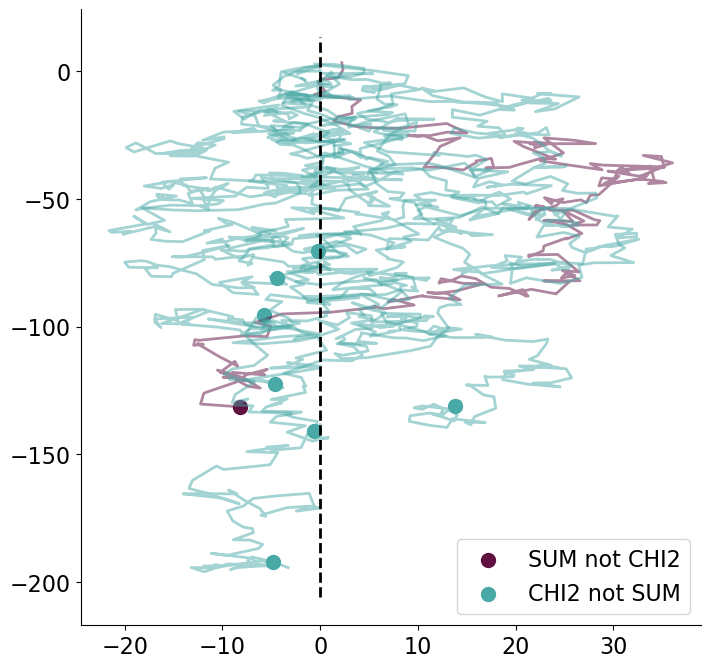

In [10]:
fig, ax = plt.subplots(figsize = (8, 8))
only_sum_right = np.setdiff1d(np.argwhere(wrong_pred_sum).flatten(), np.argwhere(wrong_pred_chi2).flatten())

limit_index = np.sum(t < interval[1])

# Plot trajectories which are predicted wrongly by just one model
for arg in only_sum_right:
    x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

    color = "C0"

    ax.plot(x[t <= interval[1]], y[t <= interval[1]], color = color, linewidth = 2, alpha = 0.50)

ax.scatter(IQ_test[only_sum_right, :limit_index, 0].sum(axis = 1), IQ_test[only_sum_right, :limit_index, 1].sum(axis = 1), color = "C0", s = 100, alpha = 1, label = "SUM not CHI2")

only_chi2_right = np.setdiff1d(np.argwhere(wrong_pred_chi2).flatten(), np.argwhere(wrong_pred_sum).flatten())

# Plot trajectories which are predicted wrongly by just one model
for arg in only_chi2_right:
    x, y = IQ_test[arg, :, 0].cumsum(), IQ_test[arg, :, 1].cumsum()

    color = "C1"

    ax.plot(x[t <= interval[1]], y[t <= interval[1]], color = color, linewidth = 2, alpha = 0.50)


ax.scatter(IQ_test[only_chi2_right, :limit_index, 0].sum(axis = 1), IQ_test[only_chi2_right, :limit_index, 1].sum(axis = 1), color = "C1", s = 100, alpha = 1, label = "CHI2 not SUM")

ax.vlines(0, *ax.get_ylim(), color = "k", linestyle = "--", linewidth = 2)

ax.legend()

In [11]:
only_chi2_right, only_sum_right

(array([ 84, 304, 401, 585, 613, 790, 922]), array([366]))